# "Global Land Cover" Widget

This widget is a donut chart which shows the land cover breakdown of a particlular region using the classifications found in the Global Land Cover layer in GFW.

The donut chart should display data for each of the classification types in area(ha) and relative area (%) as well as the year the data was collected (currently only 2015, but we can expand this to cover the last 20 years of global cover data)

User Variables:

1. Admin-0, -1 and -2 region
2. area or %
3. year (WIP)

Tabs: ['Land Cover']

In [1]:
import os
import ee
import json
import requests
import requests_cache
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ee.Initialize()

In [2]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [3]:
# http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-PUG-v2.5.pdf
# http://maps.elie.ucl.ac.be/CCI/viewer/download.php#usertool

"""Note that there exists nuch finer resolution breakdowns than shown here... 
maybe we could give users to see a more detailed breakdown if they wish?"""

global_class_dict = {
    
    'class_0': 'No data',
    'class_10': 'Agriculture',
        'class_11': 'Agriculture',
        'class_12': 'Agriculture',
    'class_20': 'Agriculture',
    'class_30': 'Agriculture',
    'class_40': 'Agriculture',
    'class_50': 'Forest',
        'class_51': 'Forest',
        'class_52': 'Forest',
    'class_60': 'Forest',
        'class_61': 'Forest',
        'class_62': 'Forest',
    'class_70': 'Forest',
        'class_71': 'Forest',
        'class_72': 'Forest',
    'class_80': 'Forest',
        'class_81': 'Forest',
        'class_82': 'Forest',
    'class_90': 'Forest',
    'class_100': 'Shrubland',
    'class_110': 'Shrubland',
    'class_120': 'Shrubland',
        'class_121': 'Shrubland',
        'class_122': 'Shrubland',
    'class_130': 'Grassland',
    'class_140': 'Sparse vegetation',
    'class_150': 'Sparse vegetation',
        'class_151': 'Sparse vegetation',
        'class_152': 'Sparse vegetation',
        'class_153': 'Sparse vegetation',
    'class_160': 'Wetland',
    'class_170': 'Wetland',
    'class_180': 'Wetland',
    'class_190': 'Settlement',
    'class_200': 'Bare',
        'class_201': 'Bare',
        'class_202': 'Bare',
    'class_210': 'Water',
    'class_220': 'Permanent Snow and Ice'
    
}

In [ ]:
# http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-PUG-v2.5.pdf
# http://maps.elie.ucl.ac.be/CCI/viewer/download.php#usertool

"""These are the original land class categories"""

og_classes = {
    
    'class_0': 'No data',
    'class_10': 'Rainfed Cropland',
        'class_11': 'Herbaceous Rainfed Cropland',
        'class_12': 'Tree or Shrub Rainfed Cropland',
    'class_20': 'Irrigated Cropland',
    'class_30': 'Mosaic Cropland',
    'class_40': 'Mosaic Natural Vegetation',
    'class_50': 'Evergreen Broadleaf Treecover',
        'class_51': 'Closed Evergreen Broadleaf Treecover (>40%)',
        'class_52': 'Open Evergreen Broadleaf Treecover (<40%)',
    'class_60': 'Deciduous Broadleaf Treecover (>15%)',
        'class_61': 'Closed Deciduous Broadleaf Treecover (>40%)',
        'class_62': 'Open Deciduous Broadleaf Treecover (<40%)',
    'class_70': 'Evergreen Needleleaf Treecover (>15%)',
        'class_71': 'Closed Evergreen Needleleaf Treecover (>40%)',
        'class_72': 'Open Evergreen Needleleaf Treecover (<40%)',
    'class_80': 'Deciduous Needleleaf Treecover',
        'class_81': 'Closed Deciduous Needleleaf Treecover (>40%)',
        'class_82': 'Open Deciduous Needleleaf Treecover (<40%)',
    'class_90': 'Mixedleaf Treecover',
    'class_100': 'Mosaic Tree and Shrub',
    'class_110': 'Mosaic Hebaceous cover',
    'class_120': 'Shrubland',
        'class_121': 'Evergreen Shrubland',
        'class_122': 'Deciduous Shrubland',
    'class_130': 'Grassland',
    'class_140': 'Lichens and mosses',
    'class_150': 'Sparse vegetation',
        'class_151': 'Sparse Treecover',
        'class_152': 'Sparse Shrub',
        'class_153': 'Sparse Herbaceous cover',
    'class_160': 'Freshwater Flooded Treecover',
    'class_170': 'Saltwater Flooded Treecover',
    'class_180': 'Flooded Shrubland',
    'class_190': 'Urban Areas',
    'class_200': 'Bare Areas',
        'class_201': 'Consolidated Bare Areas',
        'class_202': 'Consolidated Bare Areas',
    'class_210': 'Water Bodies',
    'class_220': 'Permanent Snow and Ice'
    
}

In [4]:
# Make the query and return data
def classification_query(year=2015, adm0='BRA', adm1=None, adm2 = None):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT * "
               f"FROM global_land_cover_adm2 "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} ")
               
    elif adm1:
        print('Request for adm1 area')
        sql = (f"SELECT * "
               f"FROM global_land_cover_adm2 "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} ")
               
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT * "
               f"FROM global_land_cover_adm2 "
               f"WHERE iso = '{adm0}' ")
    
    account = 'wri-01'
    urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

    sql = {"q": sql}
    r = requests.get(urlCarto, params=sql)
    print(r.url,'\n')
    # pprint(r.json())
    data = r.json().get('rows')
    
    return data

In [5]:
# Sum data together for each category and calculate are(ha) and area(%) for each

def buildData(data):
    areas = {}
    #Sum all class categories together
    for d in data:
        for k, v in d.items():
            if 'class_' in k:
                if global_class_dict[k] not in areas:
                    areas[global_class_dict[k]] = 0

                areas[global_class_dict[k]] += v

    # get total area of region
    total = 0            
    for k,v in areas.items():
        total += v

    # build data up by calculating area and %
    class_data = []
    other = 0
    for k,v in areas.items():
        if v/total >= 0.001:
            class_data.append({

                'class': k,
                'area_ha': v * 300 * 300 * 1e-4,
                'area_%': 100 * v / total

            })
        # exclude gategories with zero area, and collect small (<.1%) % areas together as 'Other'
        elif v/total < 0.001 and v > 0:
            other += v
            
    class_data.append({

                'class': 'Other',
                'area_ha': other * 300 * 300 * 1e-4,
                'area_%': 100 * other / total

            })
        
    return sorted(class_data, key=lambda k: k.get('area_ha'), reverse=True)
    

In [9]:
def showPie(plot_data):
    areaId_to_name = None
    if adm2:
        tmp = get_admin2_json(iso=adm0, adm1=adm1)
        areaId_to_name ={}
        for row in tmp:
            areaId_to_name[row.get('adm2')] = row.get('name')
    if adm1 and not adm2:
        tmp = get_admin1_json(iso=adm0)
        areaId_to_name={}
        for row in tmp:
            areaId_to_name[row.get('adm1')] = row.get('name')
    
    if adm0 and not adm1 and not adm2:
        title = (f"{iso_to_countries[adm0]}")
    if adm0 and adm1 and not adm2: 
        title = (f"{areaId_to_name[adm1]}")
    if adm0 and adm1 and adm2:
        title = (f"{areaId_to_name[adm2]}")

    labels = [d.get('class') + f" ({round(d.get('area_%'),2)})%" for d in plot_data]
    sizes = [d.get('area_ha') for d in plot_data]

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(sizes, shadow=False, startangle=90)
    ax1.axis('equal')

    plt.legend(labels, loc="best",bbox_to_anchor=(1.1, 1))

    centre_circle = plt.Circle((0,0),0.75,color='white', fc='white',linewidth=0.5)

    fig1 = plt.gcf()
    fig1.gca().add_artist(centre_circle)
    plt.title('Land cover for ' + title)
    plt.show()

In [15]:
def getSentence(plot_data): 
    
    areaId_to_name = None
    if adm2:
        tmp = get_admin2_json(iso=adm0, adm1=adm1)
        areaId_to_name ={}
        for row in tmp:
            areaId_to_name[row.get('adm2')] = row.get('name')
    if adm1 and not adm2:
        tmp = get_admin1_json(iso=adm0)
        areaId_to_name={}
        for row in tmp:
            areaId_to_name[row.get('adm1')] = row.get('name')
            
    if adm0 and not adm1 and not adm2:
        title = (f"{iso_to_countries[adm0]}")
    if adm0 and adm1 and not adm2: 
        title = (f"{areaId_to_name[adm1]}")
    if adm0 and adm1 and adm2:
        title = (f"{areaId_to_name[adm2]}")

    print(f"The land use of ", end="")
    print(f"{title} in {year} is mostly {plot_data[0].get('class')}, ", end="")
    print(f"covering an area of {int(plot_data[0].get('area_ha'))}ha.", end="")


***
### Examples

Request for  adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27BRA%27+ 



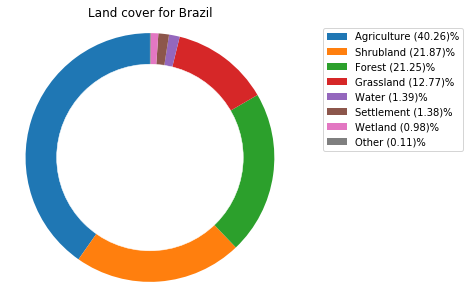

The land use of Brazil in 2015 is mostly Agriculture, covering an area of 1994404ha.

In [21]:
adm0 = 'BRA'
adm1 = None
adm2 = None
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)

Request for adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+1+ 



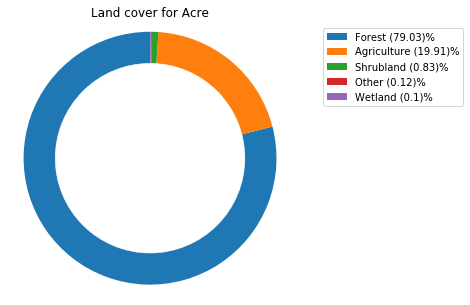

The land use of Acre in 2015 is mostly Forest, covering an area of 15647ha.

In [23]:
adm0 = 'BRA'
adm1 = 1
adm2 = None
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)

Request for adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27GBR%27+AND+adm1+%3D+1+ 



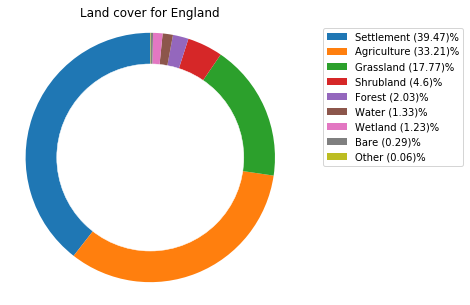

The land use of England in 2015 is mostly Settlement, covering an area of 39780ha.

In [20]:
adm0 = 'GBR'
adm1 = 1
adm2 = None
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)

Request for  adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27RUS%27+ 



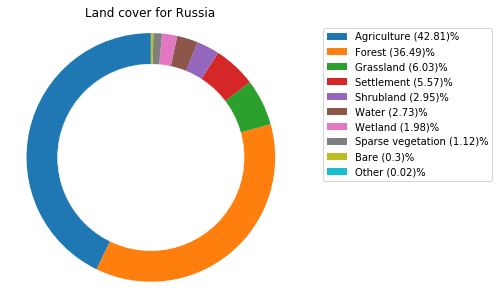

The land use of Russia in 2015 is mostly Agriculture, covering an area of 940583ha.

In [22]:
adm0 = 'RUS'
adm1 = None
adm2 = None
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)

Request for  adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27IDN%27+ 



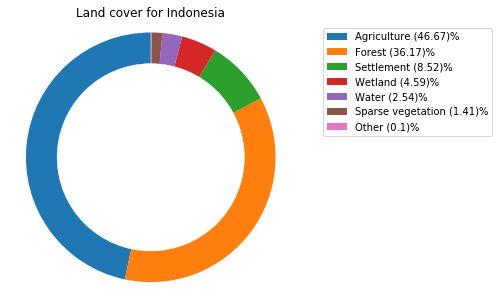

The land use of Indonesia in 2015 is mostly Agriculture, covering an area of 186480ha.

In [24]:
adm0 = 'IDN'
adm1 = None
adm2 = None
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)

Request for adm2 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+%2A+FROM+global_land_cover_adm2+WHERE+iso+%3D+%27IDN%27+AND+adm1+%3D+1+AND+adm2+%3D+1+ 



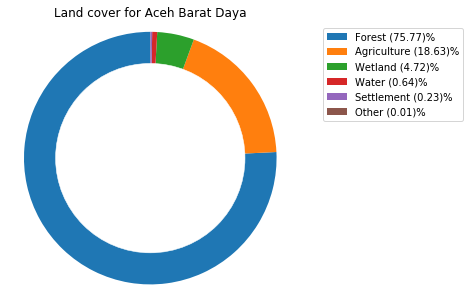

The land use of Aceh Barat Daya in 2015 is mostly Forest, covering an area of 681ha.

In [26]:
adm0 = 'IDN'
adm1 = 1
adm2 = 1
year = 2015

data = classification_query(adm0=adm0, adm1=adm1,adm2=adm2)
data = buildData(data)
showPie(data)
getSentence(data)